# PREDICT 


Intro

 Problem Statement

In [1]:
#Imports
# Data manipulation
import numpy as np 
import pandas as pd   
import re

# Ignore warnings 
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Data visualization
import matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
sns.set(style="whitegrid")
sns.set_style("dark")

# Building recommender systems
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

ModuleNotFoundError: No module named 'surprise'

In [2]:
#importing of dataframes we working with
movies=pd.read_csv('movies.csv')
imdb_data = pd.read_csv('imdb_data.csv')
tags = pd.read_csv('tags.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [6]:
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [7]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [10]:
# Count the number of unique entries for features of interest
unique_movies = len(movies['movieId'].unique().tolist())
unique_tags = len(tags['tag'].unique().tolist())
unique_users = len(train['userId'].unique().tolist())
unique_directors = len(imdb_data['director'].unique().tolist())
unique_actors = len(imdb_data['title_cast'].unique().tolist())


# Create a dataframe to store the number of unique entries for features of interest
unique = pd.DataFrame({"movies": [unique_movies],
                       "tags" : [unique_tags],
                       "users": [unique_users],
                       "directors" : [unique_directors],
                       "actors" : [unique_actors]}, index=['unique_entries'])


print('number of unique entries for features of interest')
display(unique.transpose())


number of unique entries for features of interest


,unique_entries
movies,62423
tags,73051
users,162541
directors,11787
actors,17144


In [11]:
# Determine and display the min and max ratings received
min_rating = train.rating.min()
max_rating = train.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

Lowest rating: 0.5
Highest rating: 5.0


#observations from raw data

There are over 60000 unique movies and 160000 unique users in the dataset

There are a few tables with more information about the movies, these are all related by the movieId key

Info about individual movies: Title, cast, runtime, budget, director, genre, plot keywords, tags and ratings

Movies are rated between 0 and 5: with the lowest rating being 0.5 and the highest 5.


In [17]:
#particular movie features we want to look at 
df = imdb_data[['movieId','title_cast','director', 'plot_keywords']]
df = df.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995)
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995)
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995)


In [18]:
#Clean-up Code
# Convert data types to strings for string handling
df['title_cast'] = df.title_cast.astype(str)
df['plot_keywords'] = df.plot_keywords.astype(str)
df['genres'] = df.genres.astype(str)
df['director'] = df.director.astype(str)

# Removing spaces between names
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:3])

# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))

df.head()


,movieId,title_cast,director,plot_keywords,genres,title
0,1,"[tomhanks, timallen, donrickles]",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,"[robinwilliams, jonathanhyde, kirstendunst]",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,"[waltermatthau, jacklemmon, sophialoren]",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,"[whitneyhouston, angelabassett, lorettadevine]",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,"[stevemartin, dianekeaton, martinshort]",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


In [ ]:
EDA

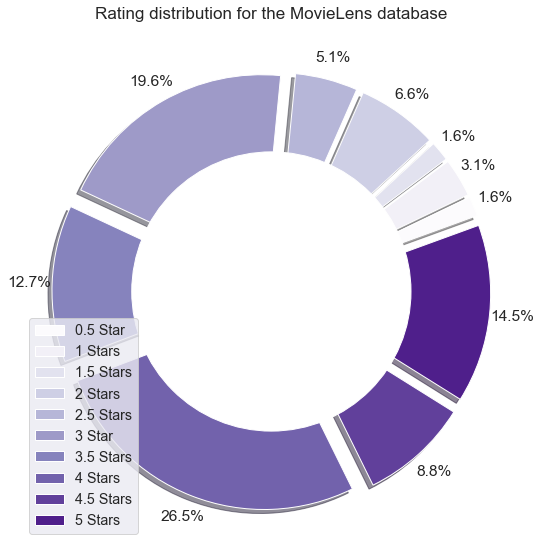

In [38]:
# Merge train with movies to join movie titles and ratings 
ratings = train.merge(movies, on='movieId', how='inner')
ratings.drop('timestamp', axis=1, inplace=True)

# Count ratings in each category (5 star to 0.5 star)
grouped = pd.DataFrame(ratings.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Creating plots 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create colour palette
labels = ['0.5 Star', '1 Stars', '1.5 Stars', '2 Stars', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
theme = plt.get_cmap('Purples')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.3)

# Create pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 shadow=True,
                 startangle=20,
                 pctdistance=1.115,
                 explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# donut chart creation
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display donut plot with legend
plt.legend(pie[0], labels, loc="lower left")
ax.set_title('Rating distribution for the MovieLens database\n', fontsize=17)
plt.tight_layout()
plt.show()

In [ ]:
initial observations:
    -bulk portion of ratings- 4 stars with 26.5%
    -smallest portion of the ratings -0.5 star with 1.6%
    -5 star ratings-14.5% of the overall ratings (is the 3rd largest portion)

In [ ]:
Release Year

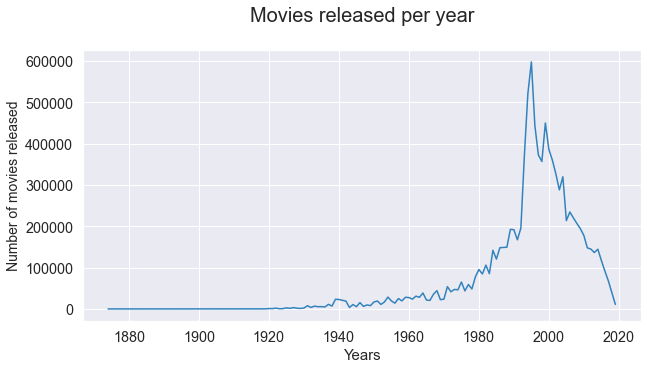

In [50]:
# Extraction of release year fron the movie titles
ratings['release_year'] = ratings.title.map(lambda x: re.findall('\d\d\d\d', x))
ratings.release_year = ratings.release_year.apply(lambda x: np.nan if not x else int(x[-1]))
years =  pd.DataFrame(ratings.groupby(['release_year'])['title'].count())
years.rename(columns={'title':'movies released'}, inplace=True)

# number of movies released per year
plt.figure(figsize=(10,5))
plot = sns.lineplot(data=years, dashes=False, legend=False, palette='tab20c')

# Add figure labels
plt.xlabel('Years', fontsize=15)
plt.ylabel('Number of movies released', fontsize=14)
plt.title('Movies released per year\n', fontsize=20)

plt.show() 

observations:
    Spike in movies produced in 1990 and 2000
    1880 to 1930-virtually no movies in the dataset from that time period
    sudden decline of movies released from 2000 to 2020

In [ ]:
#COLOUR PALETTES
'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r

Distribution of average ratings of each movie

Caution:stats could be misleading as a movie can make it to the top of the list even if only a single user has given it five stars.
Generally,movies that are really a good get many high ratings
Using this knowledge, we will record the number of ratings each film has received.

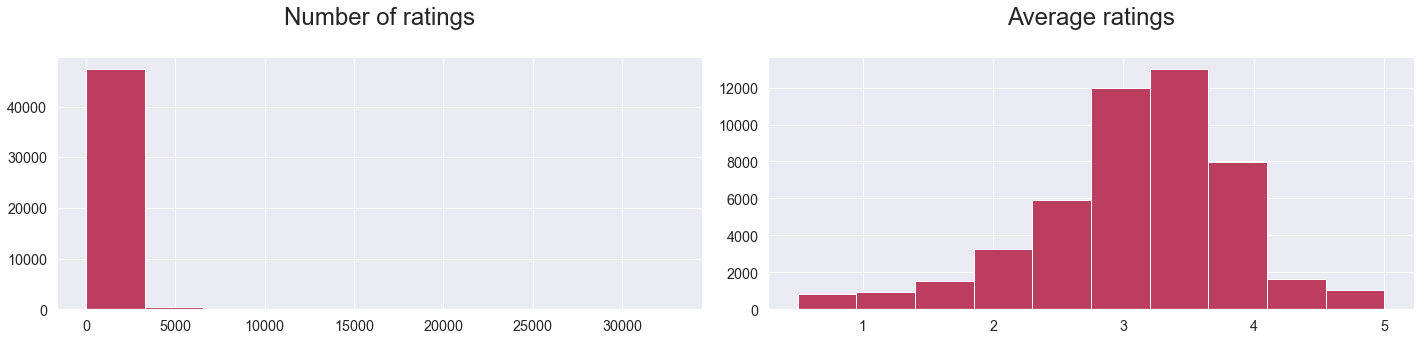

In [57]:
# average rating and number of ratings for each movie
ratings_mean_count = pd.DataFrame(ratings.groupby(['title'])[['rating']].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count())
ratings_mean_count['popularity'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count()*ratings.groupby(['title'])['rating'].mean())

# plot of the number of ratings 
f, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].hist(ratings_mean_count['rating_counts'], bins=10, color='#bb3d60')
axarr[0].set_title('Number of ratings\n', fontsize=24)

# plot showing the average ratings distribution 
axarr[1].hist(ratings_mean_count['rating'], bins=10, color='#bb3d60')
axarr[1].set_title('Average ratings\n', fontsize=24)

# Display both plots
plt.tight_layout()
plt.show()

In [ ]:
observations:
    avr ratings are slightly skewed to right- people are generous with their ratings of generally 3 and above
    mean rating is about 3ish or so 
    
    